In [ ]:
# STEP 1: USER SETTINGS
# University to analyze: "boise_state", "eastern_oregon", "university of alabama at birmingham", or "all" (to compare all three)
university_choice = "all"  # @param ["bsu", "eastern_oregon", "uab", "all"]

# KPI to run (only totals available in the Excel files; no Budget in generalized dataset)
kpi_to_run = "Total Graduates"  # @param ["Enrollment", "Employees", "R&D Expenditure", "Total Graduates"]

# Forecast horizon (years ahead)
forecast_years = 4  # @param {type:"slider", min:1, max:10, step:1}

# LSTM settings
lstm_units = 24               # @param {type:"slider", min:8, max:128, step:8}
lstm_activation = "tanh"   # @param ["tanh", "relu", "sigmoid"]

# Random Forest settings
rf_lags = 4                   # number of past years we feed in as features
rf_estimators = 200           # number of trees

# Validation split (chronological; no shuffle)
SPLIT_RATIO = 0.8             # 80% train, 20% test
MIN_TEST_POINTS = 2           # keep at least 2 points for testing

# Learning rate for the LSTM optimizer
LEARNING_RATE = 0.003

# Local paths for the Excel files you already downloaded from MinIO (kept at project root)
EXCEL_PATHS = {
    "bsu":          "boise_state_kpi.xlsx",
    "eastern_oregon": "eastern_oregon_kpi.xlsx",
    "uab":            "uab_kpi.xlsx",
}

# Rename a couple headers so they’re easy to use in code
COLUMN_RENAME = {
    "R&D Expenditure (Millions USD)": "R&D_MUSD",
}

#  labels used in plots/tables
LABELS = {
    "Enrollment":        "Total Enrollment",
    "Employees":         "Total Employees",
    "R&D_MUSD":          "R&D Expenditure (Millions USD)",
    "Total_Graduates":   "Total Graduates",
}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/l

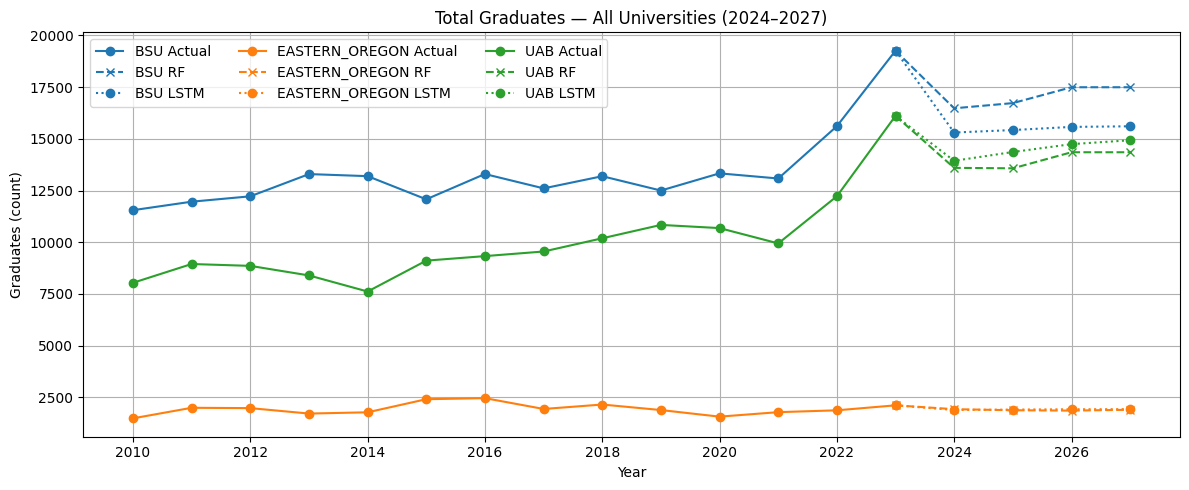

,BSU Random Forest,BSU LSTM,EASTERN_OREGON Random Forest,EASTERN_OREGON LSTM,UAB Random Forest,UAB LSTM
2024-01-01,16476,15304,1928,1888,13596,13937
2025-01-01,16727,15424,1876,1910,13574,14363
2026-01-01,17494,15576,1859,1924,14351,14743
2027-01-01,17494,15606,1899,1931,14351,14931



 80/20 Validation — (All Universities)


,University,KPI,Model,R2,MAE,MSE,RMSE,MAPE%
0,BSU,Total Graduates,Random Forest,0.6584,1090.6667,2.196875e+06,1482.1858,6.1024
1,BSU,Total Graduates,Naive(last),-1.0956,2819.6667,1.347646e+07,3671.0291,15.7655
2,BSU,Total Graduates,LSTM,-1.2216,2847.3333,1.428677e+07,3779.7846,15.7911
3,EASTERN_OREGON,Total Graduates,Random Forest,0.5651,86.3333,8.451000e+03,91.9293,4.3961
4,EASTERN_OREGON,Total Graduates,Naive(last),-6.5460,356.6667,1.466447e+05,382.9421,18.1254
5,EASTERN_OREGON,Total Graduates,LSTM,-6.6484,335.3333,1.486353e+05,385.5325,16.8251
6,UAB,Total Graduates,Random Forest,0.5326,1494.0000,3.029534e+06,1740.5557,11.5490
7,UAB,Total Graduates,LSTM,-0.1957,2225.6667,7.750252e+06,2783.9275,15.9510
8,UAB,Total Graduates,Naive(last),-0.6643,2569.0000,1.078739e+07,3284.4156,17.9105


In [ ]:
# STEP 3: MULTIVARIATE VALIDATION + FORECASTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# LSTM
use_lstm = True
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.optimizers import Adam
    import tensorflow.keras.backend as K
    tf.config.run_functions_eagerly(True)
except Exception:
    print("TensorFlow not available — LSTM steps will be skipped (Random Forest still runs).")
    use_lstm = False

from IPython.display import display
np.random.seed(42)

# helpers
def make_optimizer(lr=LEARNING_RATE):
    return Adam(learning_rate=lr)

def mape(y_true, y_pred):
    yt = np.asarray(y_true, dtype=float)
    yp = np.asarray(y_pred, dtype=float)
    mask = yt != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((yt[mask] - yp[mask]) / yt[mask])) * 100.0

def metric_row(name, y_true, y_pred):
    return {
        "Model": name,
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred) ** 0.5,
        "MAPE%": mape(y_true, y_pred),
    }

def split_index(n, split=SPLIT_RATIO, min_test=MIN_TEST_POINTS, min_train=rf_lags+3):
    si = max(int(n * split), min_train)
    if n - si < min_test:
        si = n - min_test
    return si

def y_axis_label(label_text):
    if "R&D" in label_text:       return "R&D Spending (Millions USD)"
    if "Graduate" in label_text:  return "Graduates (count)"
    if "Enrollment" in label_text:return "Students (count)"
    if "Employee" in label_text:  return "Employees (count)"
    return label_text

def round_like_humans(x, label_text):
    if any(k in label_text for k in ["Enrollment","Employee","Graduate","Students"]):
        return int(np.round(x))
    return float(np.round(x, 2))

# load Excel
def load_excel_kpis(excel_path):

    df = pd.read_excel(excel_path)
    df.columns = [c.strip() for c in df.columns]
    df = df.rename(columns=COLUMN_RENAME)

    keep = ["Date", "Enrollment", "Employees", "R&D_MUSD", "Total_Graduates"]
    keep = [c for c in keep if c in df.columns]
    df = df[keep].copy()

    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date").set_index("Date")

    for col in [c for c in df.columns if c != "Date"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").interpolate("linear").ffill().bfill()
    return df

def choose_series(df_one_uni, kpi_name):
    if kpi_name == "R&D Expenditure":
        if "R&D_MUSD" in df_one_uni.columns:
            return df_one_uni["R&D_MUSD"], LABELS["R&D_MUSD"]
        raise KeyError("'R&D Expenditure' not found in this file.")
    if kpi_name == "Total Graduates":
        if "Total_Graduates" in df_one_uni.columns:
            return df_one_uni["Total_Graduates"], LABELS["Total_Graduates"]
        raise KeyError("'Total Graduates' not found in this file.")
    if kpi_name == "Enrollment":
        if "Enrollment" in df_one_uni.columns:
            return df_one_uni["Enrollment"], LABELS["Enrollment"]
        raise KeyError("'Enrollment' not found in this file.")
    if kpi_name == "Employees":
        if "Employees" in df_one_uni.columns:
            return df_one_uni["Employees"], LABELS["Employees"]
        raise KeyError("'Employees' not found in this file.")
    raise KeyError(f"Unknown KPI: {kpi_name}")

#  80/20 validation (multivariate)
def validate_series_multivariate(series, pretty_label, df_all_cols):
    """
    80/20 split validation:
      • RF (multivariate): target lags + contemporaneous covariates
      • LSTM (multivariate): window of [target + other KPIs] → next target
      • Naive baseline (last value)
    """
    s = series.sort_index().astype(float).interpolate().ffill().bfill()
    n = len(s)
    if n < max(rf_lags + 3, 8):
        print(f"[{pretty_label}] Not enough data to validate (n={n}).")
        return None

    si = split_index(n)
    train, test = s.iloc[:si], s.iloc[si:]
    y_true = test.values
    rows = []

    # Naive
    naive_preds = np.repeat(train.iloc[-1], len(test))
    rows.append(metric_row("Naive(last)", y_true, naive_preds))

    # RF (multivariate)
    covars = df_all_cols.drop(columns=[series.name])
    lag = pd.DataFrame({"y": s})
    for i in range(1, rf_lags+1):
        lag[f"lag_{i}"] = lag["y"].shift(i)
    X_full = lag.join(covars, how="inner").dropna()

    if not X_full.empty:
        X_tr = X_full.iloc[:si].drop(columns=["y"]).values
        y_tr = X_full.iloc[:si]["y"].values
        rf_model = RandomForestRegressor(n_estimators=rf_estimators, random_state=42)
        rf_model.fit(X_tr, y_tr)

        preds = []
        hist_target = s.iloc[:si].copy()
        idx_test = s.index[si:]
        for t in range(len(idx_test)):
            lag_vals = hist_target.iloc[-rf_lags:].values
            cov_vals = covars.loc[idx_test[t]].values
            x = np.concatenate([lag_vals, cov_vals]).reshape(1, -1)
            y_hat = rf_model.predict(x)[0]
            preds.append(round_like_humans(y_hat, pretty_label))
            hist_target = pd.concat([hist_target, pd.Series([preds[-1]], index=[idx_test[t]])])
        rows.append(metric_row("Random Forest", y_true, np.array(preds)))

    # LSTM (multivariate)
    if use_lstm:
        target_col = series.name
        covar_cols = [c for c in df_all_cols.columns if c != target_col]

        scaler_y  = MinMaxScaler().fit(train.values.reshape(-1,1))
        scaler_x  = MinMaxScaler().fit(df_all_cols.loc[train.index, covar_cols].values)

        y_tr_s = scaler_y.transform(train.values.reshape(-1,1))
        X_tr_s = scaler_x.transform(df_all_cols.loc[train.index, covar_cols].values)
        feats  = np.concatenate([y_tr_s, X_tr_s], axis=1)

        X_l, y_l = [], []
        for i in range(len(feats) - rf_lags):
            X_l.append(feats[i:i+rf_lags, :])
            y_l.append(y_tr_s[i+rf_lags, 0])
        if len(X_l) > 0:
            X_l = np.array(X_l); y_l = np.array(y_l).reshape(-1, 1)

            K.clear_session()
            lstm = Sequential([
                LSTM(lstm_units, activation=lstm_activation, input_shape=(rf_lags, X_l.shape[2])),
                Dropout(0.1),
                Dense(1)
            ])
            lstm.compile(optimizer=make_optimizer(), loss="mse")
            _ = lstm.fit(X_l, y_l, epochs=200, validation_split=0.25, verbose=0,
                         callbacks=[EarlyStopping(patience=12, restore_best_weights=True)])

            X_te_s = scaler_x.transform(df_all_cols.loc[test.index, covar_cols].values)
            window = np.concatenate([y_tr_s, X_tr_s], axis=1)[-rf_lags:, :].copy()

            lstm_preds = []
            for k in range(len(test)):
                nxt_s = float(lstm.predict(window.reshape(1, rf_lags, -1), verbose=0).squeeze())
                next_row = np.concatenate([[nxt_s], X_te_s[k]]).astype(float)
                window   = np.vstack([window[1:], next_row])
                y_inv = scaler_y.inverse_transform(np.array([[nxt_s]])).ravel()[0]
                lstm_preds.append(round_like_humans(y_inv, pretty_label))
            rows.append(metric_row("LSTM", y_true, np.array(lstm_preds)))

    metrics = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
    return metrics

# predict
def predict_series_multivariate(series, pretty_label, df_all_cols, years_ahead=forecast_years):
    """
    Returns: (rf_forecast, lstm_forecast_or_None, future_index)
    """
    s = series.sort_index().astype(float).interpolate().ffill().bfill()
    future_index = pd.date_range(start=f"{s.index.max().year+1}-01-01",
                                 periods=years_ahead, freq="YS")

    # RF (multivariate)
    other_cols = df_all_cols.drop(columns=[series.name])
    lag = pd.DataFrame({"y": s})
    for i in range(1, rf_lags+1):
        lag[f"lag_{i}"] = lag["y"].shift(i)
    X_full = lag.join(other_cols, how="inner").dropna()

    X = X_full.drop(columns=["y"]).values
    y = X_full["y"].values
    rf_model = RandomForestRegressor(n_estimators=rf_estimators, random_state=42)
    rf_model.fit(X, y)

    history_for_rf = s.copy()
    last_cov = other_cols.iloc[-1].values  # simple hold-last covariates
    rf_fore = []
    for _ in range(years_ahead):
        last_lags = history_for_rf.iloc[-rf_lags:].values
        x_in = np.concatenate([last_lags, last_cov]).reshape(1, -1)
        y_hat = rf_model.predict(x_in)[0]
        rf_fore.append(round_like_humans(y_hat, pretty_label))
        history_for_rf.loc[history_for_rf.index.max() + pd.offsets.YearBegin()] = rf_fore[-1]
    rf_fore = np.array(rf_fore)

    # LSTM (multivariate)
    lstm_fore = None
    if use_lstm:
        target_col = series.name
        covar_cols = [c for c in df_all_cols.columns if c != target_col]

        sc_y = MinMaxScaler().fit(s.values.reshape(-1,1))
        sc_x = MinMaxScaler().fit(df_all_cols.loc[s.index, covar_cols].values)

        y_all_s = sc_y.transform(s.values.reshape(-1,1))
        X_all_s = sc_x.transform(df_all_cols.loc[s.index, covar_cols].values)
        feats = np.concatenate([y_all_s, X_all_s], axis=1)

        X_l, y_l = [], []
        for i in range(len(feats) - rf_lags):
            X_l.append(feats[i:i+rf_lags, :])
            y_l.append(y_all_s[i+rf_lags, 0])

        if len(X_l) > 0:
            X_l = np.array(X_l); y_l = np.array(y_l).reshape(-1, 1)

            K.clear_session()
            lstm = Sequential([
                LSTM(lstm_units, activation=lstm_activation, input_shape=(rf_lags, X_l.shape[2])),
                Dropout(0.1),
                Dense(1)
            ])
            lstm.compile(optimizer=make_optimizer(LEARNING_RATE), loss="mse")
            _ = lstm.fit(
                X_l, y_l, epochs=200, validation_split=0.25, verbose=0,
                callbacks=[EarlyStopping(patience=12, restore_best_weights=True)]
            )

            last_cov_s = sc_x.transform(df_all_cols.loc[[s.index[-1]], covar_cols].values)[0]
            window = feats[-rf_lags:, :].copy()
            preds_s = []
            for _ in range(years_ahead):
                nxt_s = float(lstm.predict(window.reshape(1, rf_lags, -1), verbose=0).squeeze())
                next_row = np.concatenate([[nxt_s], last_cov_s]).astype(float)
                window = np.vstack([window[1:], next_row])
                preds_s.append(nxt_s)

            lstm_raw = sc_y.inverse_transform(np.array(preds_s).reshape(-1,1)).ravel()
            lstm_fore = np.array([round_like_humans(v, pretty_label) for v in lstm_raw])

    return rf_fore, lstm_fore, future_index

# run single university
def run_one_university(uni_key, kpi_name):
    excel_path = EXCEL_PATHS[uni_key]
    df_uni = load_excel_kpis(excel_path)
    series, label = choose_series(df_uni, kpi_name)

    # validation table (this uni only)
    metrics = validate_series_multivariate(series, label, df_uni)
    print(f"\n 80/20 Validation — {uni_key.upper()} — {label}")
    display(metrics.round(4))

    # quick single-uni forecast plot (history + RF + LSTM)
    rf_fore, lstm_fore, future_idx = predict_series_multivariate(series, label, df_uni, years_ahead=forecast_years)
    plt.figure(figsize=(10,4))
    plt.plot(series.index, series.values, 'o-', label="Actual (history)")
    plt.plot([series.index[-1]] + list(future_idx), [series.values[-1]] + list(rf_fore), '--x', label="Random Forest")
    if lstm_fore is not None:
        plt.plot([series.index[-1]] + list(future_idx), [series.values[-1]] + list(lstm_fore), ':o', label="LSTM")
    plt.title(f"{uni_key.upper()} — {label} ({future_idx.year[0]}–{future_idx.year[-1]})")
    plt.xlabel("Year"); plt.ylabel(y_axis_label(label))
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    out = pd.DataFrame({"Random Forest": rf_fore}, index=future_idx)
    if lstm_fore is not None:
        out["LSTM"] = lstm_fore
    display(out.round(2))

#  run all three + single combined validation table
def run_all_universities_with_one_table(kpi_name):
    """
    Makes exactly one overlay chart (history + RF + LSTM for each uni)
    and prints one combined validation metrics table with a 'University' column.
    """
    schools = ["bsu", "eastern_oregon", "uab"]
    color = {"bsu": "C0", "eastern_oregon": "C1", "uab": "C2"}

    fig, ax = plt.subplots(figsize=(12, 5))
    tables = []
    all_val_rows = []   # we’ll store all validation rows here
    last_label = kpi_name
    any_future_idx = None

    for uni_key in schools:
        try:
            df_uni = load_excel_kpis(EXCEL_PATHS[uni_key])
            series, label = choose_series(df_uni, kpi_name)
            last_label = label
        except Exception as e:
            print(f"Skipping {uni_key.upper()}: {e}")
            continue

        # 80/20 validation — collect into one big table
        metrics = validate_series_multivariate(series, f"{label}", df_uni)
        if metrics is not None and not metrics.empty:
            tmp = metrics.copy()
            tmp.insert(0, "University", uni_key.upper())
            tmp.insert(1, "KPI", label)
            all_val_rows.append(tmp)

        # forecast values for overlay
        rf_fore, lstm_fore, future_idx = predict_series_multivariate(series, label, df_uni, years_ahead=forecast_years)
        any_future_idx = future_idx

        # overlay: history + RF + LSTM
        ax.plot(series.index, series.values, 'o-', color=color[uni_key], label=f"{uni_key.upper()} Actual")
        ax.plot([series.index[-1]] + list(future_idx), [series.values[-1]] + list(rf_fore),
                '--x', color=color[uni_key], label=f"{uni_key.upper()} RF")
        if lstm_fore is not None:
            ax.plot([series.index[-1]] + list(future_idx), [series.values[-1]] + list(lstm_fore),
                    ':o', color=color[uni_key], label=f"{uni_key.upper()} LSTM")

        # table for this uni
        out = pd.DataFrame({"Random Forest": rf_fore}, index=future_idx)
        if lstm_fore is not None:
            out["LSTM"] = lstm_fore
        tables.append(out.add_prefix(f"{uni_key.upper()} "))

    # finish combined chart
    if any_future_idx is not None:
        ax.set_title(f"{kpi_name} — All Universities ({any_future_idx.year[0]}–{any_future_idx.year[-1]})")
    else:
        ax.set_title(f"{kpi_name} — All Universities")
    ax.set_xlabel("Year")
    ax.set_ylabel(y_axis_label(last_label))
    ax.grid(True)
    ax.legend(ncol=3)
    plt.tight_layout()
    plt.show()

    # one side-by-side forecast table
    if tables:
        display(pd.concat(tables, axis=1).round(2))

    # one combined validation metrics table
    if all_val_rows:
        big_val = pd.concat(all_val_rows, axis=0, ignore_index=True)
        # Optional: sort so the best (lowest RMSE) rows float to the top within each uni/KPI
        big_val = big_val.sort_values(["University", "KPI", "RMSE"]).reset_index(drop=True)
        print("\n 80/20 Validation — (All Universities)")
        display(big_val.round(4))
    else:
        print("No validation metrics to show (likely not enough data).")

# STEP 4: DISPATCH
if university_choice == "all":
    run_all_universities_with_one_table(kpi_to_run)
else:
    run_one_university(university_choice, kpi_to_run)
